# Kkma를 활용한 형태소 분석



## 1. KoNLPy - Kkma

KoNLPy는 다음과 같은 다양한 형태소 분석, 태깅 라이브러리를 파이썬에서 쉽게 사용할 수 있도록 함

- Hannanum: 한나눔. KAIST Semantic Web Research Center 개발(http://semanticweb.kaist.ac.kr/hannanum/)

- Kkma: 꼬꼬마. 서울대학교 IDS(Intelligent Data Systems) 연구실 개발(http://kkma.snu.ac.kr/)

- Komoran: 코모란. Shineware에서 개발(https://github.com/shin285/KOMORAN)

- Mecab: 메카브. 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정(https://bitbucket.org/eunjeon/mecab-ko)

- Open Korean Text: 오픈 소스 한국어 분석기. 과거 트위터 형태소 분석기(https://github.com/open-korean-text/open-korean-text)

**꼬꼬마 형태소 분석기**

꼬꼬마 프로젝트는 서울대학교 IDS (Intelligent Data Systems) 연구실에서 자연어 처리를 하기 위한 다양한 모듈 및 자료를 구축하기 위한 과제로 크게 '형태소 분석기 및 자연어 처리 모듈 개발' 부분과 '세종 말뭉치 활용 시스템'으로 구분된다.

In [ ]:
# KoNLPy 설치
!pip install konlpy

In [ ]:
# mecab 설치를 위한 스크립트
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

## 2. 형태소 분석에 사용할 데이터

- 네이버 영화 리뷰 데이터(ratings.txt)
- Naver sentiment movie corpus v1.0
- 출처 : https://github.com/e9t/nsmc

In [ ]:
# 사용할 데이터 불러오기
from google.colab import files
uploaded = files.upload()

Saving ratings.txt to ratings.txt


In [ ]:
# 네이버 영화 리뷰 데이터 확인
import pandas as pd
data = pd.read_csv('ratings.txt', sep='\t')

In [ ]:
# id : 사용자 아이디
# document : 사용자 리뷰
# label : 긍/부정 감성(긍정:1, 부정:0)
# 20만개 데이터로 구성
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [ ]:
data.isnull().sum() # NULL 값 유무 확인

id          0
document    8
label       0
dtype: int64

In [ ]:
review_data = data.dropna(axis=0) # NULL 값이 있는 행 제거
print(review_data .isnull().sum()) # NULL 값 유무 재확인

id          0
document    0
label       0
dtype: int64


In [ ]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199992 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        199992 non-null  int64 
 1   document  199992 non-null  object
 2   label     199992 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


## 3. 형태소 분석(Part Of Speech, POS)

- 형태소는 '뜻을 가진 가장 작은 말의 단위'
- '책가방' -> '책', '가방'
- 명사, 대명사, 수사, 조사, 동사, 형용사, 관형사, 부사, 감탄사

In [ ]:
# 형태소 단위로 Tokenizing 하기
# Tokenizing : 텍스트 정보를 단위별로 나누는 것
# KoNLPy의 분석기는 Kkma, Okt, Komoran, Hannanum, Mecab
# morphs() : 텍스트를 형태소 단위로 나눔
# nouns() : 텍스트에서 명사만 추출
# phrases() : 텍스트에서 어절 추출
# pos() : 텍스트를 형태소 단위로 나눈 뒤, 형태소와 품사 정보를 리스트화

from konlpy.tag import Kkma, Komoran, Okt, Hannanum, Mecab
okt = Okt()
kkm = Kkma()
kom = Komoran()
han = Hannanum()
mecab = Mecab()

In [ ]:
# 예시문
review_data['document'][15]

'평점 왜 낮아? 긴장감 스릴감 진짜 최고인데 진짜 전장에서 느끼는 공포를 생생하게 전해준다.'

In [ ]:
# pos() 함수로 형태소 분석 태깅
kkm_pos = kkm.pos(review_data['document'][15])
kkm_pos

[('평점', 'NNG'),
 ('왜', 'MAG'),
 ('낮', 'VA'),
 ('아', 'ECD'),
 ('?', 'SF'),
 ('긴장감', 'NNG'),
 ('스릴', 'NNG'),
 ('감', 'NNG'),
 ('진짜', 'NNG'),
 ('최고', 'NNG'),
 ('이', 'VCP'),
 ('ㄴ데', 'ECE'),
 ('진짜', 'MAG'),
 ('전장', 'NNG'),
 ('에서', 'JKM'),
 ('느끼', 'VV'),
 ('는', 'ETD'),
 ('공포', 'NNG'),
 ('를', 'JKO'),
 ('생생', 'XR'),
 ('하', 'XSA'),
 ('게', 'ECD'),
 ('전하', 'VV'),
 ('어', 'ECS'),
 ('주', 'VXV'),
 ('ㄴ다', 'EFN'),
 ('.', 'SF')]

In [ ]:
# morphs() 함수로 형태소 분석
kkm_mor = kkm.morphs(review_data['document'][15])
kkm_mor

['평점',
 '왜',
 '낮',
 '아',
 '?',
 '긴장감',
 '스릴',
 '감',
 '진짜',
 '최고',
 '이',
 'ㄴ데',
 '진짜',
 '전장',
 '에서',
 '느끼',
 '는',
 '공포',
 '를',
 '생생',
 '하',
 '게',
 '전하',
 '어',
 '주',
 'ㄴ다',
 '.']

In [ ]:
# nouns() 함수로 명사 분석
kkm_nouns = kkm.nouns(review_data['document'][15])
kkm_nouns

['평점', '긴장감', '스릴', '스릴감', '감', '진짜', '최고', '전장', '공포']

In [ ]:
# 영어 문장은 OL : 외국어 로 인식
sentence = "i love you"
kkm_eng = kkm.pos(sentence)
print(kkm_eng)

[('i', 'OL'), ('love', 'OL'), ('you', 'OL')]


In [ ]:
text = "아버지가 방에 들어가신다"
print(kkm.pos(text))

[('아버지', 'NNG'), ('가', 'JKS'), ('방', 'NNG'), ('에', 'JKM'), ('들어가', 'VV'), ('시', 'EPH'), ('ㄴ다', 'EFN')]


100%|██████████| 1000/1000 [00:11<00:00, 84.85it/s]


Text(0, 0.5, 'total seconds')

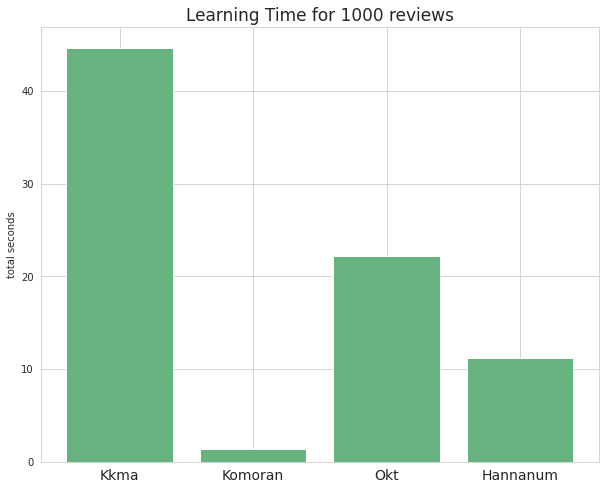

In [ ]:
# 형태소 분석 소요 시간 비교
import time
from tqdm import tqdm

def tagger_time(tagger, texts):
  time_sum = 0

  for sentence in tqdm(texts):
    t1 = time.time()
    try:
      tagger.morphs(sentence)
    except:
      pass
    t2 = time.time() 

    time_sum += (t2 - t1)

  return time_sum

texts = review_data['document'][:1000]
time_list = []

for tagger in [kkm, kom, okt, han]:
  time_list.append(tagger_time(tagger, texts))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

tagger = ['Kkma', 'Komoran', 'Okt', 'Hannanum']

plt.figure(figsize=(10,8))
plt.bar(tagger, time_list, color=(0.4,0.7,0.5))
plt.title('Learning Time for 1000 reviews', fontsize=17)
plt.xticks(fontsize=14)
plt.ylabel('total seconds')

## 4. 평가

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 강재지침서 체크리스트 500개.xlsx to 강재지침서 체크리스트 500개.xlsx


In [ ]:
# 강재지침서 체크리스트 질문 데이터셋
df = pd.read_excel('강재지침서 체크리스트 500개.xlsx')
df = df['질문']
df

0         강재지침서 총칙에 명시된 강재지침서의 목적은 ?
1      강재지침서 총칙에 명시된 강재지침서의 적용 대상은 ?
2        강재지침서를 관리하는 책임을 갖고 있는 사람은 ?
3       강재지침서의 개선사항은 누구에게 제출해야 하는가 ?
4                      강재지침서의 관리자는 ?
                   ...              
494                     강재대체시 고려사항은?
495            잔재 예약이 자동으로 해지되는 기간은?
496                     잔재현황의 보관기간은?
497                   매각용 잔재의 호선번호는?
498                 잔재관리 제반 자료의 기준은?
Name: 질문, Length: 499, dtype: object

In [ ]:
# 체크리스트 질문 500개에 대해서 형태소 분석
for sentence in df.values:
  print(sentence)
  print('Kkma : ', kkm.pos(sentence))
  print('Okt : ', okt.pos(sentence))
  print('Mecab : ', mecab.pos(sentence))

강재지침서 총칙에 명시된 강재지침서의 목적은 ?
Kkma :  [('강재', 'NNG'), ('지침서', 'NNG'), ('총칙', 'NNG'), ('에', 'JKM'), ('명시', 'NNG'), ('되', 'XSV'), ('ㄴ', 'ETD'), ('강재', 'NNG'), ('지침서', 'NNG'), ('의', 'JKG'), ('목적', 'NNG'), ('은', 'JX'), ('?', 'SF')]
Okt :  [('강재', 'Noun'), ('지침', 'Noun'), ('서', 'Josa'), ('총칙', 'Noun'), ('에', 'Josa'), ('명시', 'Noun'), ('된', 'Verb'), ('강재', 'Noun'), ('지침', 'Noun'), ('서', 'Josa'), ('의', 'Noun'), ('목적', 'Noun'), ('은', 'Josa'), ('?', 'Punctuation')]
Mecab :  [('강재', 'NNG'), ('지침서', 'NNG'), ('총칙', 'NNG'), ('에', 'JKB'), ('명시', 'NNG'), ('된', 'XSV+ETM'), ('강재', 'NNG'), ('지침서', 'NNG'), ('의', 'JKG'), ('목적', 'NNG'), ('은', 'JX'), ('?', 'SF')]
강재지침서 총칙에 명시된 강재지침서의 적용 대상은 ?
Kkma :  [('강재', 'NNG'), ('지침서', 'NNG'), ('총칙', 'NNG'), ('에', 'JKM'), ('명시', 'NNG'), ('되', 'XSV'), ('ㄴ', 'ETD'), ('강재', 'NNG'), ('지침서', 'NNG'), ('의', 'JKG'), ('적용', 'NNG'), ('대상', 'NNG'), ('은', 'JX'), ('?', 'SF')]
Okt :  [('강재', 'Noun'), ('지침', 'Noun'), ('서', 'Josa'), ('총칙', 'Noun'), ('에', 'Josa'), ('명시', 'Noun'), ('된', 'Ve

100%|██████████| 498/498 [00:00<00:00, 15493.32it/s]


Text(0, 0.5, 'total seconds')

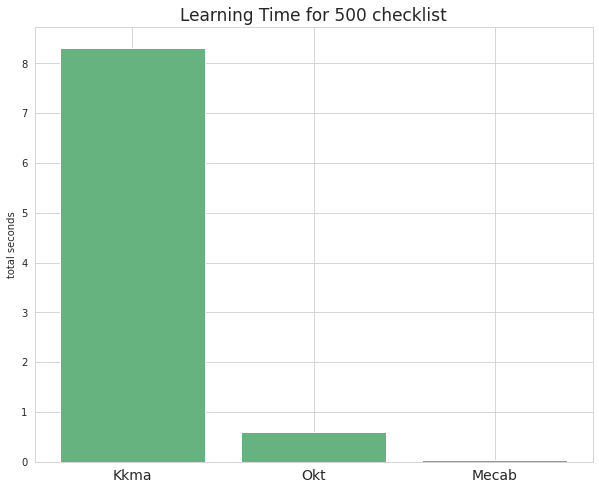

In [ ]:
# 강재지침서 데이터 대상 형태소 분석 소요 시간 비교
import time
from tqdm import tqdm

def tagger_time(tagger, texts):
  time_sum = 0

  for sentence in tqdm(texts):
    t1 = time.time()
    try:
      tagger.morphs(sentence)
    except:
      pass
    t2 = time.time() 

    time_sum += (t2 - t1)

  return time_sum

texts = df[:498]
time_list = []

for tagger in [kkm, okt, mecab]:
  time_list.append(tagger_time(tagger, texts))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

tagger = ['Kkma', 'Okt', 'Mecab']

plt.figure(figsize=(10,8))
plt.bar(tagger, time_list, color=(0.4,0.7,0.5))
plt.title('Learning Time for 500 checklist', fontsize=17)
plt.xticks(fontsize=14)
plt.ylabel('total seconds')